In [1]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
from abstention.calibration import PlattScaling, IsotonicRegression


In [2]:
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import get_ambig_binary_crossentropy
import pickle 
from kerasAC.generators import * 
from scipy.special import logit 

Using TensorFlow backend.


In [3]:
#on brahma, SNPs have been split by DL CV split 
snp_prefix="/srv/scratch/annashch/gecco/gwas_summary_dl_splits"
n_folds=10 
num_tasks=5 
all_snps_basename="variants.with.rsid.naomit.bed"
cred_set_basename="99percent_cred_set.naomit.bed"
cred_set_noncoding_basename="99percent_cred_set_no_ld_coding.naomit.bed"
ref_fasta="/mnt/data/annotations/by_release/hg19.GRCh37/hg19.genome.fa"

In [4]:
#calibrate classification predictions         


def calibrate(snp_ref_logits,
              snp_alt_logits,
              test_set_prediction_logits,
              test_set_labels): 
    #avoid -inf values and inf values:                                                                                                                               
    pseudocount=1e-5
    
    ntasks=snp_ref_logits.shape[1]
    #perform calibration for each task!                                                                                                                              
    calibrated_ref_predictions=None
    calibrated_alt_predictions=None 
    for i in range(ntasks):
        #don't calibrate on nan inputs
        try:
            test_set_labels=test_set_labels.values
        except:
            pass
        nonambiguous_indices=np.argwhere(~np.isnan(test_set_labels[:,i]))
        classification_calibration_func = PlattScaling()(
        valid_preacts=test_set_prediction_logits[nonambiguous_indices,i],
        valid_labels=test_set_labels[nonambiguous_indices,i])
        calibrated_ref_predictions_task=classification_calibration_func(snp_ref_logits[:,i])
        calibrated_alt_predictions_task=classification_calibration_func(snp_alt_logits[:,i])
        if calibrated_ref_predictions is None:
            calibrated_ref_predictions=np.expand_dims(calibrated_ref_predictions_task,axis=1)
        else:
            calibrated_ref_predictions=np.concatenate((calibrated_ref_predictions,
                                                       np.expand_dims(calibrated_ref_predictions_task,axis=1)),
                                                      axis=1)
        if calibrated_alt_predictions is None:
            calibrated_alt_predictions=np.expand_dims(calibrated_alt_predictions_task,axis=1)
        else:
            calibrated_alt_predictions=np.concatenate((calibrated_alt_predictions,
                                                       np.expand_dims(calibrated_alt_predictions_task,axis=1)),
                                                      axis=1)
    return calibrated_ref_predictions, calibrated_alt_predictions 

In [5]:
outf=open("SNP_effect_predictions.txt",'w')
outf.write("\t".join(['Chrom','StartPos','EndPos','Ref','Alt','Rsid']))
for field in ['RefLogit','RefCalibrated','AltLogit','AltCalibrated']: 
    for task in ['dnase_c','dnase_v','sw480','hct116','colo205']: 
        outf.write('\t'+field+task)
outf.write('\n')

for fold in range(n_folds): 
    print(fold)
    #load the model
    custom_objects={"recall":recall,
                    "sensitivity":recall,
                    "specificity":specificity,
                    "fpr":fpr,
                    "fnr":fnr,
                    "precision":precision,
                    "f1":f1,
                    "ambig_binary_crossentropy":get_ambig_binary_crossentropy()}
    model=load_model("/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/gecco.classification.SummitWithin200bpCenter."+str(fold),custom_objects=custom_objects)
    print("loaded model")
    #load the model logits 
    predictions=pickle.load(open("/srv/scratch/annashch/deeplearning/gecco/crossvalid/v4/predictions."+str(fold),'rb'))
    test_set_prediction_logits=predictions[-2]
    test_set_labels=predictions[1]
    print("got test set logits and labels")
    #get reference allele predictions 
    snp_file='/'.join([snp_prefix,all_snps_basename])+'.'+str(fold)
    snps=pd.read_csv(snp_file,header=0,sep='\t')
    snp_ref_generator=SNPGenerator(snp_file,
                                   ref_fasta=ref_fasta,
                                   allele_col="Ref")
    snp_ref_predictions=model.predict_generator(snp_ref_generator,
                                                max_queue_size=5000, 
                                                workers=40, 
                                                use_multiprocessing=True, verbose=1)
    print("got snp ref predictions")
    #get alternate allele predictions 
    snp_alt_generator=SNPGenerator(snp_file,
                                   ref_fasta=ref_fasta,
                                  allele_col="Alt")

    snp_alt_predictions=model.predict_generator(snp_alt_generator,
                                                max_queue_size=5000, 
                                                workers=40, 
                                                use_multiprocessing=True, verbose=1)
    print("got snp alt predictions")
    #get the snp logits 
    snp_ref_logits=logit(snp_ref_predictions) 
    snp_alt_logits=logit(snp_alt_predictions)
    #calibrate reference and alternate  allele predictions 
    calibrated_ref_predictions,calibrated_alt_predictions=calibrate(snp_ref_logits,
                                        snp_alt_logits,
                                        test_set_prediction_logits,
                                        test_set_labels)
    print("calibrated SNP predictions with Platt scaling")
    num_snps=snps.shape[0]
    for snp_index in range(num_snps): 
        outf.write('\t'.join([str(j) for j in snps.iloc[snp_index]])+
                   '\t'+
                   '\t'.join([str(j) for j in snp_ref_logits[snp_index]])+
                   '\t'+
                   '\t'.join([str(j) for j in calibrated_ref_predictions[snp_index]])+
                   '\t'+
                   '\t'.join([str(j) for j in snp_alt_logits[snp_index]])+
                   '\t'+
                   '\t'.join([str(j) for j in calibrated_alt_predictions[snp_index]])+
                   '\n')
        
outf.close()     

0
loaded model
got test set logits and labels
loaded labels
filtered on chroms_to_use
10/10 [==============================] - 4s 414ms/step
got snp ref predictions
loaded labels
filtered on chroms_to_use
10/10 [==============================] - 2s 224ms/step
got snp alt predictions
Platt scaling coef: 1.3204465956684657 ; intercept: -0.5375400959521714
Platt scaling coef: 1.1826328984478807 ; intercept: -1.7693510389373772
Platt scaling coef: 1.3226312639420488 ; intercept: -1.6175231892477206
Platt scaling coef: 1.2602009048231972 ; intercept: -0.6602933027639962
Platt scaling coef: 1.4153982275041783 ; intercept: -0.18356388908744012
calibrated SNP predictions with Platt scaling
1
loaded model
got test set logits and labels
loaded labels
filtered on chroms_to_use
15/15 [==============================] - 3s 219ms/step
got snp ref predictions
loaded labels
filtered on chroms_to_use
15/15 [==============================] - 3s 199ms/step
got snp alt predictions
Platt scaling coef: 1.050

In [6]:
import pandas as pd 
snp_predictions=pd.read_csv("SNP_effect_predictions.txt",header=0,sep='\t')
snp_predictions

Chrom   StartPos     EndPos Ref Alt         Rsid  RefLogitdnase_c  \
0      chr1   22587728   22587729   T   C   rs72647484        -2.402729   
1      chr1   22637589   22637590   G   C   rs76599916        -6.597812   
2      chr1   22585236   22585237   G   A    rs3845519        -5.871217   
3      chr1   22565060   22565061   G   A    rs2807329        -0.369537   
4      chr1   22575306   22575307   G   A    rs2744752        -4.460650   
5      chr1   22566927   22566928   T   A    rs2744742        -9.626362   
6      chr1   22566847   22566848   C   T    rs2807332        -8.820500   
7      chr1   22579916   22579917   A   G  rs185441988        -9.466695   
8      chr1   22568696   22568697   G   C    rs2807334        -2.227128   
9      chr1   22590125   22590126   T   C   rs72647489        -1.080641   
10     chr1   22590009   22590010   G   A   rs72647488        -2.041760   
11     chr1   22555597   22555598   G   A    rs2807322        -5.398496   
12     chr1   22554891   22554892   C   A    rs2807321        -4.308435   
13     chr1   22528074   22528075   C   T  rs139827460       -11.405335   
14     chr1   22573764   22573765   C   T    rs2807335        -1.550626   
15     chr1   22551506   22551507   C   T    rs2744736        -5.373674   
16     chr1   22551582   22551583   C   T    rs2744737        -5.894883   
17     chr1   22552937   22552938   C   T    rs2807378        -3.797917   
18     chr1   22573163   22573164   A   G    rs2744748        -5.272286   
19     chr1   22553578   22553579   C   A    rs2807316        -3.639562   
20     chr1   22553338   22553339   G   A    rs2807315        -9.180791   
21     chr1   22553837   22553838   G   A    rs3004221        -6.303786   
22     chr1   22550049   22550050   C   T    rs2744735        -3.921793   
23     chr1   22637713   22637714   C   T  rs111864242       -10.250339   
24     chr1   22561733   22561734   C   T    rs2807324        -7.919446   
25     chr1   22576467   22576468   T   A    rs2744754        -5.724026   
26     chr1   22548994   22548995   C   T    rs2744732        -5.471014   
27     chr1   22587009   22587010   T   C   rs72647483        -5.499514   
28     chr1   22546066   22546067   C   A    rs2807344        -6.677036   
29     chr1   22584718   22584719   C   T   rs72647481        -0.049027   
...     ...        ...        ...  ..  ..          ...              ...   
23569  chr8  128459125  128459126   G   A   rs13282506       -11.855075   
23570  chr8  128465268  128465269   G   A    rs9642878        -3.813216   
23571  chr8  128430225  128430226   G   A    rs4454246       -12.479695   
23572  chr8  128430478  128430479   G   T   rs10090174        -8.832100   
23573  chr8  128408116  128408117   C   T   rs10505476        -3.523330   
23574  chr8  128430089  128430090   C   T    rs4401815       -20.096823   
23575  chr8  128453248  128453249   C   T   rs28489926       -10.138093   
23576  chr8  128429823  128429824   G   A    rs4452767        -8.524565   
23577  chr8  128447549  128447550   A   G   rs75191360        -7.686375   
23578  chr8  128429917  128429918   G   A    rs4454245        -8.945731   
23579  chr8  128453111  128453112   A   G   rs28537112        -7.446640   
23580  chr8  128429519  128429520   G   A    rs6470509        -9.195971   
23581  chr8  128429721  128429722   T   C    rs6985419       -10.555837   
23582  chr8  128429510  128429511   G   A    rs6470508        -9.415093   
23583  chr8  128447547  128447548   G   C  rs386729816        -8.380625   
23584  chr8  128429732  128429733   C   T    rs4500050       -10.757804   
23585  chr8  128431694  128431695   A   G    rs7842552        -4.543365   
23586  chr8  128445986  128445987   T   C   rs57889831        -8.076034   
23587  chr8  128452407  128452408   T   C   rs10101025       -18.542180   
23588  chr8  128429262  128429263   G   C    rs9297754        -3.435919   
23589  chr8  128417936  128417937   C   T   rs10505473        -8.256211   
23590  chr8  128408064  1284080

In [17]:
snp_predictions.columns

Index(['Chrom', 'StartPos', 'EndPos', 'Ref', 'Alt', 'Rsid', 'RefLogitdnase_c',
       'RefLogitdnase_v', 'RefLogitsw480', 'RefLogithct116', 'RefLogitcolo205',
       'RefCalibrateddnase_c', 'RefCalibrateddnase_v', 'RefCalibratedsw480',
       'RefCalibratedhct116', 'RefCalibratedcolo205', 'AltLogitdnase_c',
       'AltLogitdnase_v', 'AltLogitsw480', 'AltLogithct116', 'AltLogitcolo205',
       'AltCalibrateddnase_c', 'AltCalibrateddnase_v', 'AltCalibratedsw480',
       'AltCalibratedhct116', 'AltCalibratedcolo205'],
      dtype='object')

In [18]:
snp_predictions[snp_predictions['Rsid']=="rs1977415"]

Chrom   StartPos     EndPos Ref Alt       Rsid  RefLogitdnase_c  \
20179  chr9  113659190  113659191   C   T  rs1977415       -28.165567   

       RefLogitdnase_v  RefLogitsw480  RefLogithct116          ...           \
20179       -27.295736      -18.31221      -14.799498          ...            

       AltLogitdnase_c  AltLogitdnase_v  AltLogitsw480  AltLogithct116  \
20179       -20.123468       -19.993038     -12.605572      -10.657475   

       AltLogitcolo205  AltCalibrateddnase_c  AltCalibrateddnase_v  \
20179       -17.057795          5.859728e-12          3.598190e-12   

       AltCalibratedsw480  AltCalibratedhct116  AltCalibratedcolo205  
20179        1.041296e-07             0.000001          1.339870e-11  

[1 rows x 26 columns]

In [32]:
snp_predictions[snp_predictions['Rsid']=="rs1318920"]

Chrom   StartPos     EndPos Ref Alt       Rsid  RefLogitdnase_c  \
22871  chr10  101353285  101353286   C   T  rs1318920         0.248949   

       RefLogitdnase_v  RefLogitsw480  RefLogithct116          ...           \
22871         4.783099       2.824497       -2.337862          ...            

       AltLogitdnase_c  AltLogitdnase_v  AltLogitsw480  AltLogithct116  \
22871        -1.828457         1.681678        0.50735       -2.319117   

       AltLogitcolo205  AltCalibrateddnase_c  AltCalibrateddnase_v  \
22871        -2.194082               0.04842               0.61524   

       AltCalibratedsw480  AltCalibratedhct116  AltCalibratedcolo205  
22871            0.331181             0.025881              0.029279  

[1 rows x 26 columns]

In [33]:
snp_predictions.iloc[22871]

Chrom                       chr10
StartPos                101353285
EndPos                  101353286
Ref                             C
Alt                             T
Rsid                    rs1318920
RefLogitdnase_c          0.248949
RefLogitdnase_v            4.7831
RefLogitsw480              2.8245
RefLogithct116           -2.33786
RefLogitcolo205        -0.0512011
RefCalibrateddnase_c     0.388554
RefCalibrateddnase_v     0.982859
RefCalibratedsw480       0.870181
RefCalibratedhct116     0.0252884
RefCalibratedcolo205     0.402087
AltLogitdnase_c          -1.82846
AltLogitdnase_v           1.68168
AltLogitsw480             0.50735
AltLogithct116           -2.31912
AltLogitcolo205          -2.19408
AltCalibrateddnase_c    0.0484198
AltCalibrateddnase_v      0.61524
AltCalibratedsw480       0.331181
AltCalibratedhct116     0.0258812
AltCalibratedcolo205    0.0292793
Name: 22871, dtype: object

In [11]:
import plotnine
from plotnine import * 

### DNAse C 

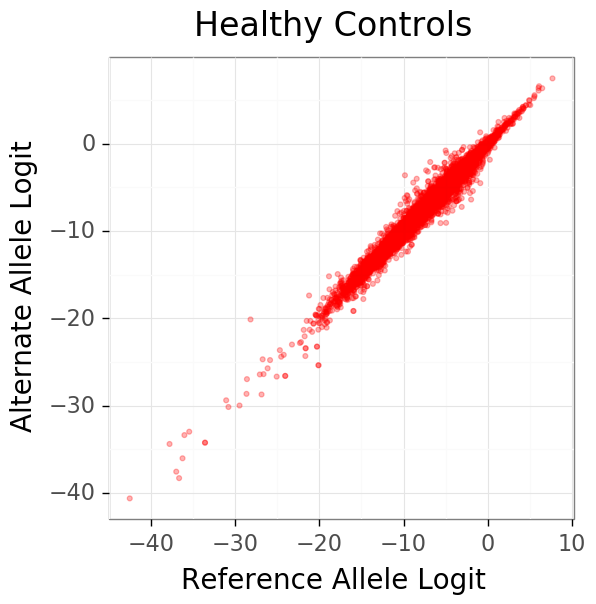

<ggplot: (8730426306985)>

In [12]:
plotnine.options.figure_size = (6,6)
(ggplot(snp_predictions,
        aes(x="RefLogitdnase_c",y="AltLogitdnase_c",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("Healthy Controls"))


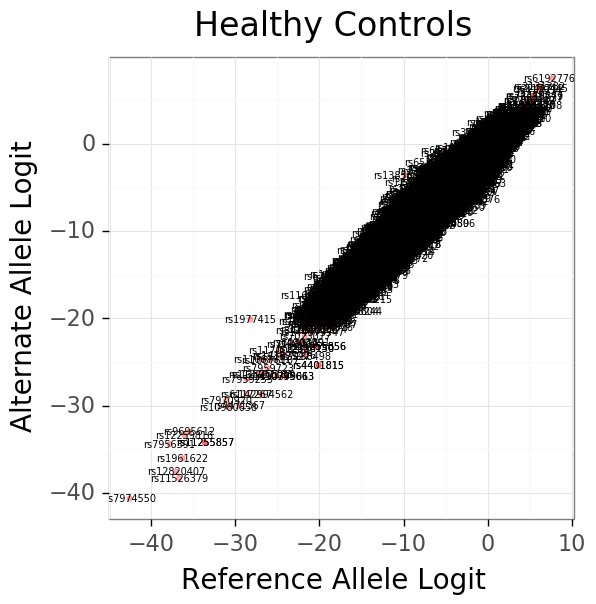

<ggplot: (8730421338986)>

In [16]:
plotnine.options.figure_size = (6,6)
(ggplot(snp_predictions,
        aes(x="RefLogitdnase_c",y="AltLogitdnase_c",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
 geom_text(size=7)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("Healthy Controls"))

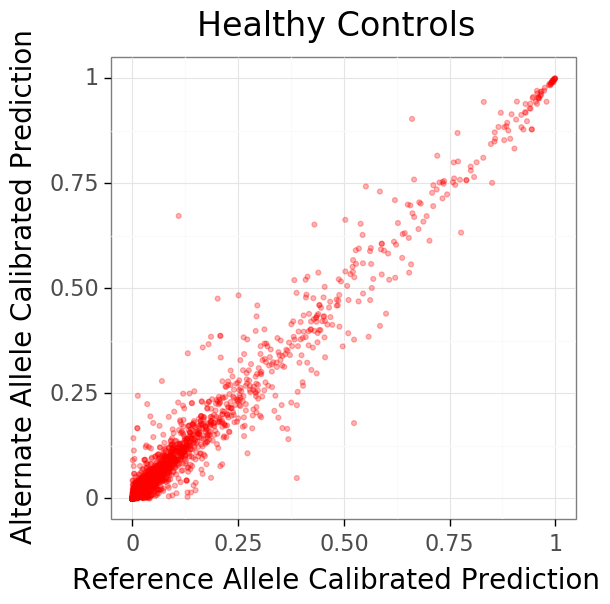

<ggplot: (8730415387235)>

In [14]:
(ggplot(snp_predictions,
        aes(x="RefCalibrateddnase_c",y="AltCalibrateddnase_c",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
ggtitle("Healthy Controls"))

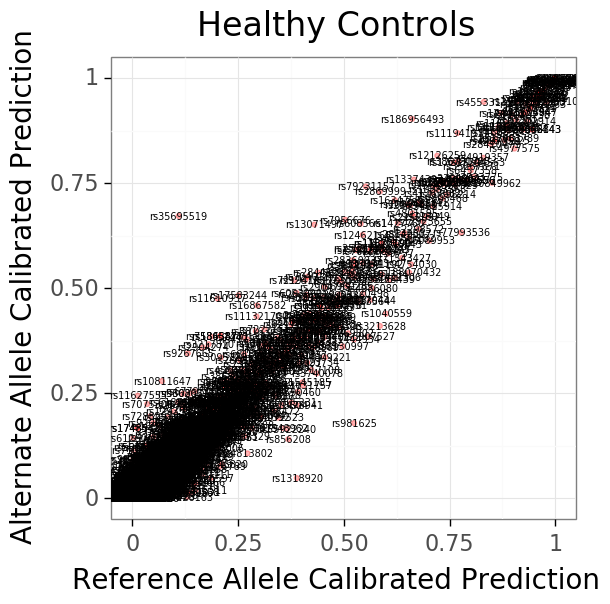

<ggplot: (8730426157309)>

In [15]:
(ggplot(snp_predictions,
        aes(x="RefCalibrateddnase_c",y="AltCalibrateddnase_c",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
 geom_text(size=7)+
ggtitle("Healthy Controls"))

## DNAse V 

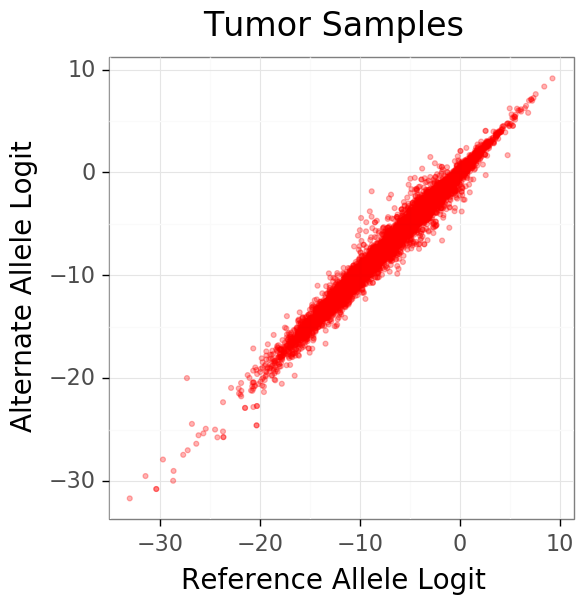

<ggplot: (8774452242913)>

In [81]:
plotnine.options.figure_size = (6,6)
(ggplot(snp_predictions,
        aes(x="RefLogitdnase_v",y="AltLogitdnase_v",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("Tumor Samples"))


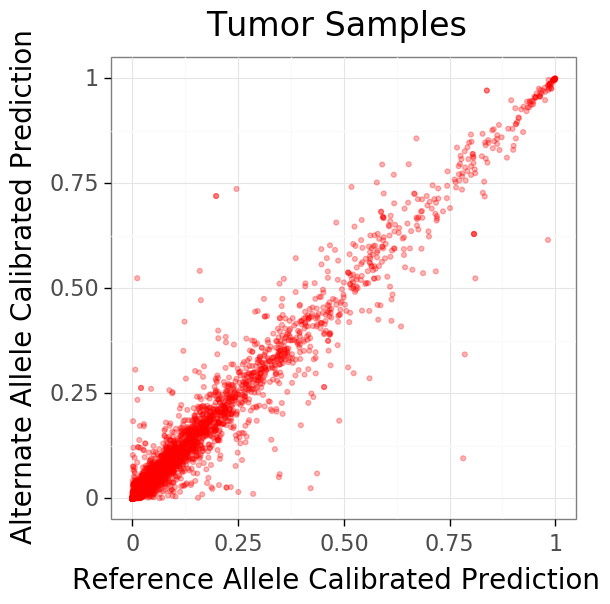

<ggplot: (8774452245112)>

In [82]:
(ggplot(snp_predictions,
        aes(x="RefCalibrateddnase_v",y="AltCalibrateddnase_v",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
ggtitle("Tumor Samples"))

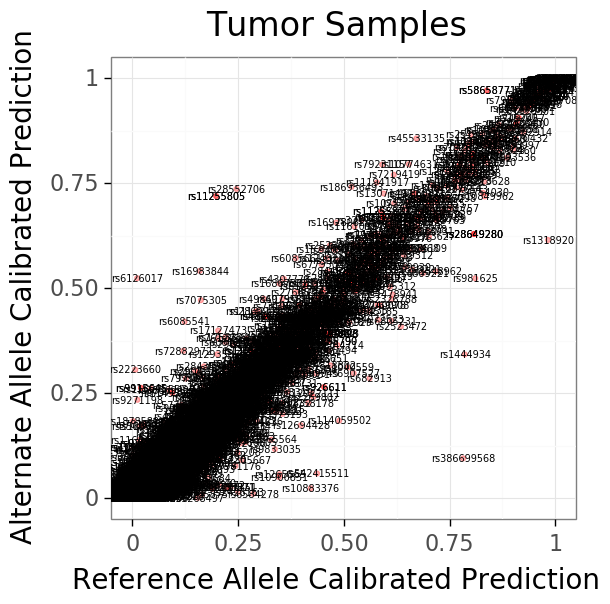

<ggplot: (-9223363262427633755)>

In [84]:
(ggplot(snp_predictions,
        aes(x="RefCalibrateddnase_v",y="AltCalibrateddnase_v",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
ggtitle("Tumor Samples")+
geom_text(size=7))

## SW480

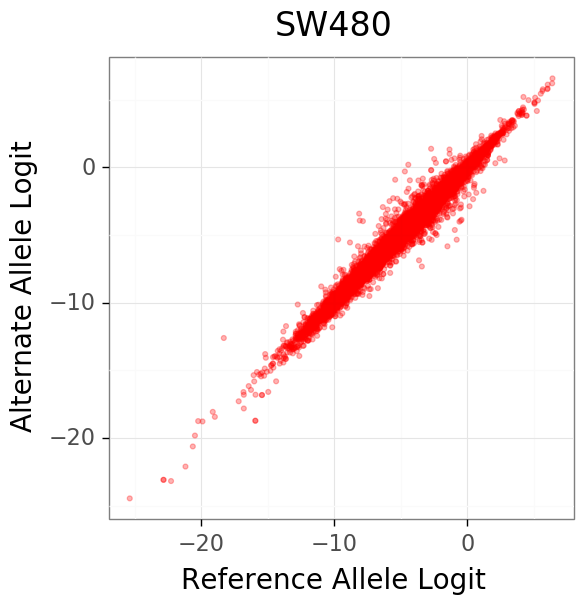

<ggplot: (-9223363262427636245)>

In [85]:
plotnine.options.figure_size = (6,6)
(ggplot(snp_predictions,
        aes(x="RefLogitsw480",y="AltLogitsw480",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("SW480"))


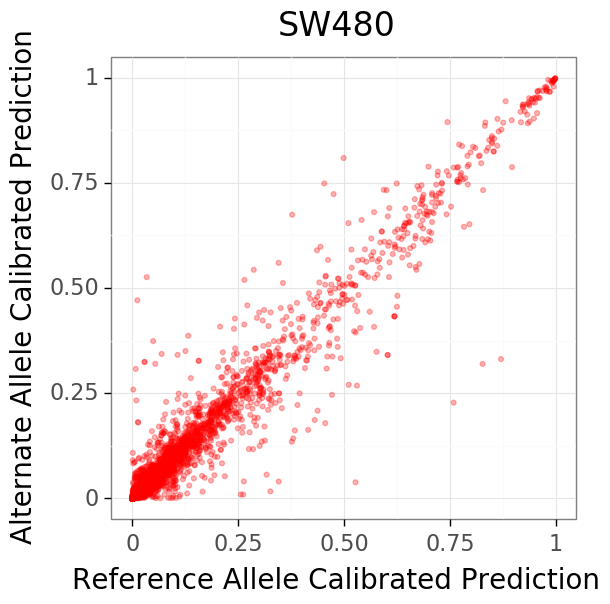

<ggplot: (-9223363262385856782)>

In [91]:
(ggplot(snp_predictions,
        aes(x="RefCalibratedsw480",y="AltCalibratedsw480",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
ggtitle("SW480"))

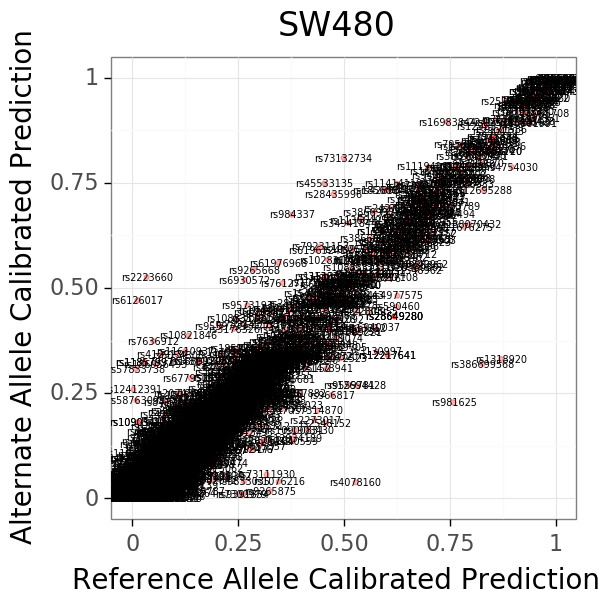

<ggplot: (-9223363262439349602)>

In [92]:
(ggplot(snp_predictions,
        aes(x="RefCalibratedsw480",y="AltCalibratedsw480",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
 geom_text(size=7)+
ggtitle("SW480"))

## HCT116

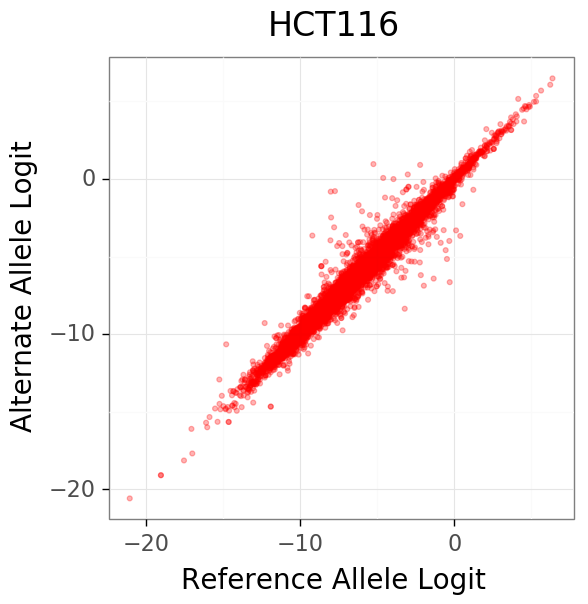

<ggplot: (8774468392989)>

In [93]:
plotnine.options.figure_size = (6,6)
(ggplot(snp_predictions,
        aes(x="RefLogithct116",y="AltLogithct116",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("HCT116"))


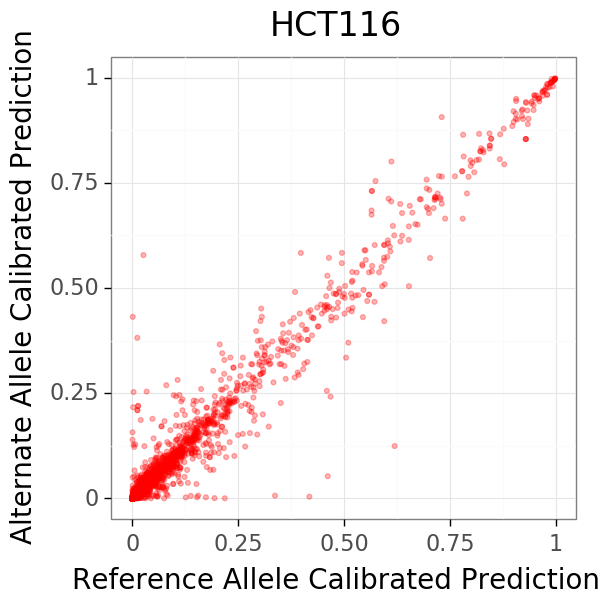

<ggplot: (8774428434878)>

In [94]:
(ggplot(snp_predictions,
        aes(x="RefCalibratedhct116",y="AltCalibratedhct116",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
ggtitle("HCT116"))

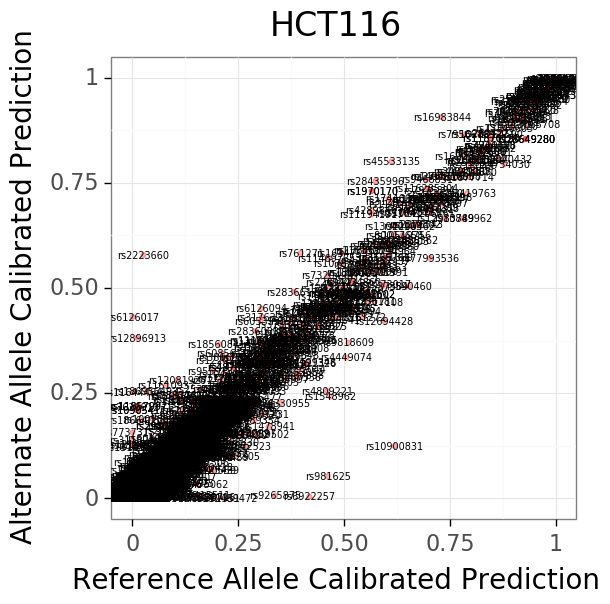

<ggplot: (-9223363262419669139)>

In [95]:
(ggplot(snp_predictions,
        aes(x="RefCalibratedhct116",y="AltCalibratedhct116",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
 geom_text(size=7)+
ggtitle("HCT116"))

## COLO205

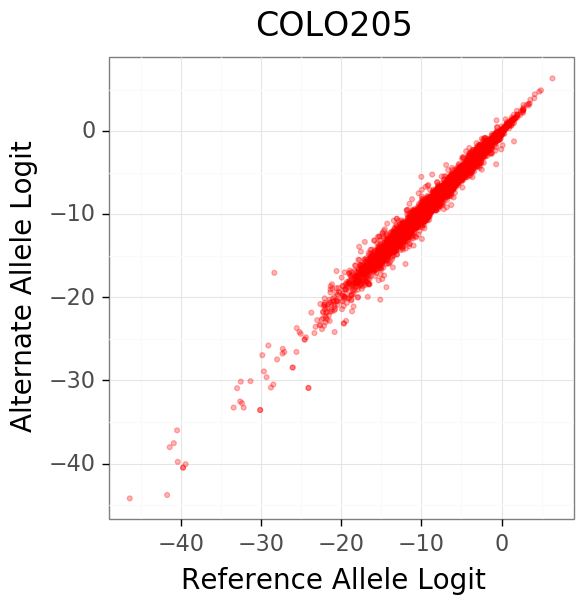

<ggplot: (-9223363262439349609)>

In [96]:
plotnine.options.figure_size = (6,6)
(ggplot(snp_predictions,
        aes(x="RefLogitcolo205",y="AltLogitcolo205",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Logit")+
ylab("Alternate Allele Logit")+
ggtitle("COLO205"))


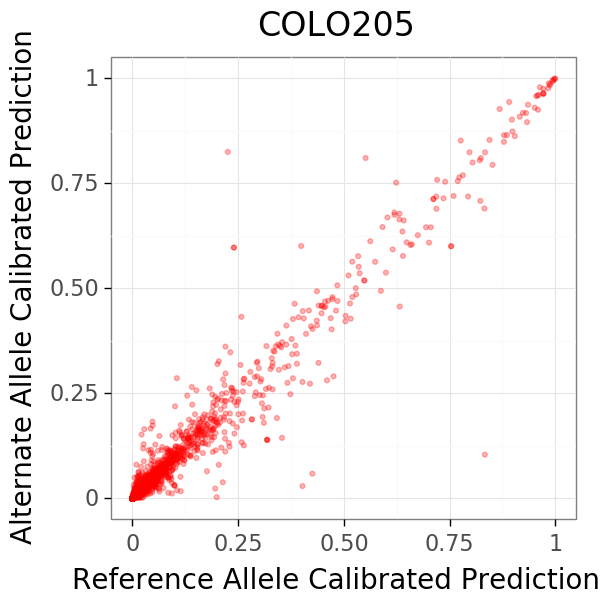

<ggplot: (-9223363262386556307)>

In [97]:
(ggplot(snp_predictions,
        aes(x="RefCalibratedcolo205",y="AltCalibratedcolo205",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
ggtitle("COLO205"))

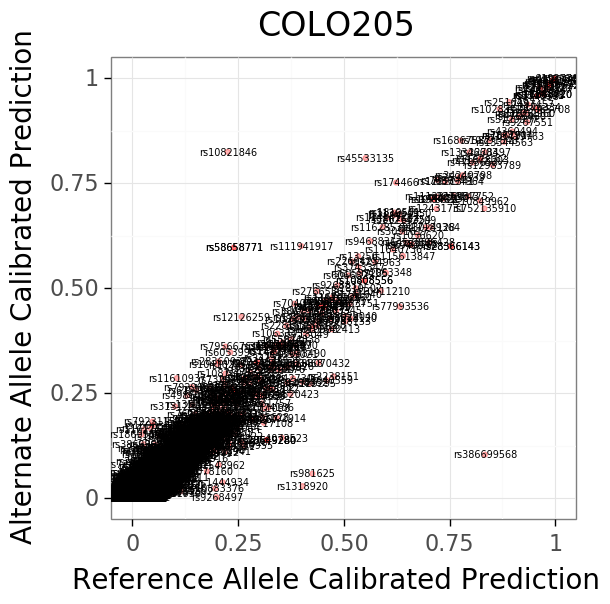

<ggplot: (-9223363262386537244)>

In [98]:
(ggplot(snp_predictions,
        aes(x="RefCalibratedcolo205",y="AltCalibratedcolo205",label='Rsid'))+
geom_point(alpha=0.3,color='red')+
theme_bw(20)+
xlab("Reference Allele Calibrated Prediction")+
ylab("Alternate Allele Calibrated Prediction")+
geom_text(size=7)+
ggtitle("COLO205"))